In [6]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

In [7]:
data = pd.read_csv('data/df_12H_imputed_with_knn.csv')
display_basic_info(data)

Shape of the DataFrame: (52536, 39)

Number of unique patients: 4378

SepsisLabel class counts:
 0.0    39402
1.0    13134
Name: SepsisLabel, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2189
1.0    2189
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP               

# Split

In [8]:
train_df, test_df = split_train_test_data_v2(data)

# Extraction des séquences et normalisation

In [9]:
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'Sepsispredicted'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((24514, 6, 36), (24514,), (6132, 6, 36), (6132,))

# Modèle

In [11]:
from tensorflow.keras.layers import InputLayer
def build_and_train_lstm_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=128):
	"""
	Construit et entraîne un modèle LSTM pour la prédiction basée sur des données séquentielles.

	Args:
	- X_train: Séquences d'entraînement (padded).
	- y_train: Labels d'entraînement.
	- X_val: Séquences de validation (padded).
	- y_val: Labels de validation.
	- input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
	- epochs: Nombre d'époques d'entraînement.
	- batch_size: Taille du lot pour l'entraînement.

	Returns:
	- keras.models.Model: Modèle LSTM entraîné.
	- keras.callbacks.History: Historique de l'entraînement.
	"""
	model = Sequential([
		InputLayer(input_shape=input_shape),
		LSTM(128, return_sequences=True),
		Dropout(0.25),
		LSTM(64),
		Dropout(0.25),
		Dense(128, activation='relu'),
		Dropout(0.25),
		Dense(1, activation='sigmoid')
	])

	model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

	# Configuration de l'arrêt prématuré
	early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

	# Entraînement du modèle
	history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

	return model, history


# Entrainement 

In [13]:
normalize_sequences_train.shape

(24514, 6, 36)

In [12]:
input_shape = (6, 35)  # time steps, features
model_1, history_1 = build_and_train_lstm_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


ValueError: Error when checking input: expected input_1 to have shape (6, 35) but got array with shape (6, 36)

In [28]:

def plot_training_history(history):
	"""
	Affiche les courbes de précision et de perte pour les ensembles d'entraînement et de validation.

	Args:
	- history: Historique de l'entraînement du modèle (history object de Keras).
	"""
	# Récupérer les données de l'historique
	accuracy = history.history['acc']
	val_accuracy = history.history['val_acc']
	loss = history.history['loss']
	val_loss = history.history['val_loss']
	epochs = range(1, len(accuracy) + 1)

	# Tracé de la précision
	plt.figure(figsize=(14, 5))

	# Courbe d'accuracy
	plt.subplot(1, 2, 1)
	plt.plot(epochs, accuracy, 'b-', label='Accuracy entraînement')
	plt.plot(epochs, val_accuracy, 'r-', label='Accuracy validation')
	plt.title('Accuracy - Entraînement vs Validation')
	plt.xlabel('Épochs')
	plt.ylabel('Accuracy')
	plt.legend()
	plt.grid(True)

	# Courbe de perte (loss)
	plt.subplot(1, 2, 2)
	plt.plot(epochs, loss, 'b-', label='Perte entraînement')
	plt.plot(epochs, val_loss, 'r-', label='Perte validation')
	plt.title('Perte - Entraînement vs Validation')
	plt.xlabel('Épochs')
	plt.ylabel('Perte')
	plt.legend()
	plt.grid(True)

	plt.tight_layout()
	plt.show()


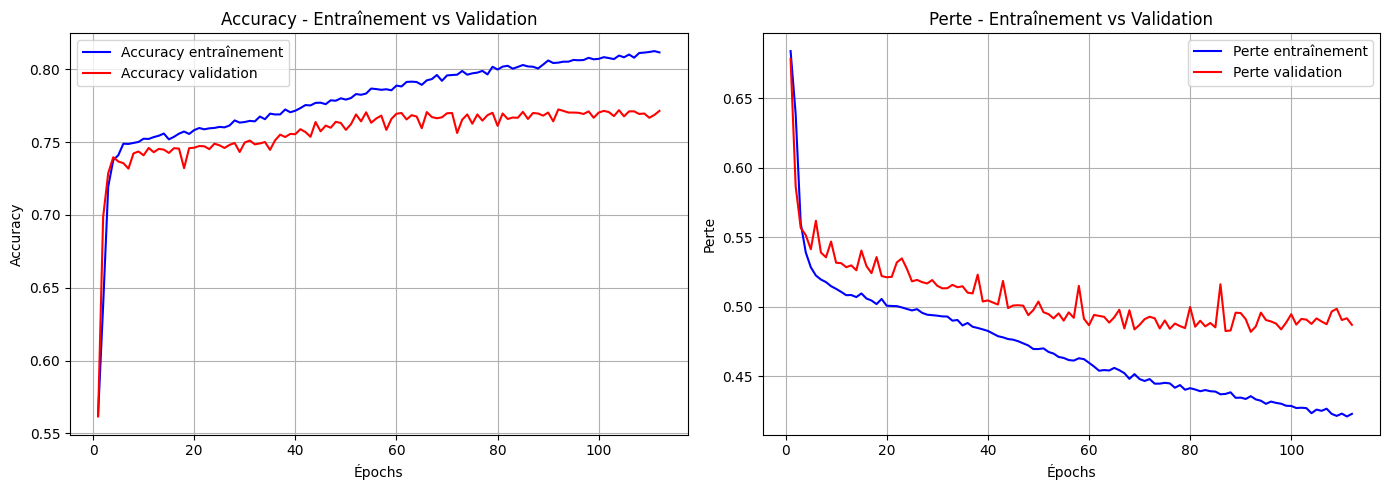

In [29]:
plot_training_history(history_1)

Accuracy: 0.7723
Precision: 0.7257
Recall: 0.7727
F1-Score: 0.7485
AUROC: 0.8453


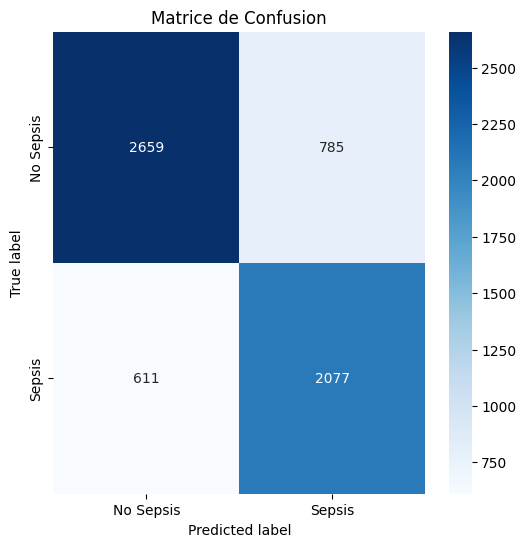

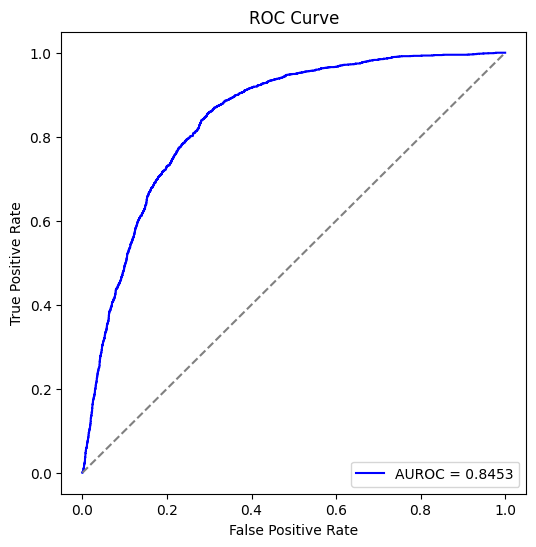

In [30]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_1, normalize_sequences_test, labels_test)

In [31]:
import tensorflow as tf


In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
# tf.compat.v1.disable_eager_execution()

In [32]:
normalize_sequences_test.shape

(6132, 6, 35)

In [33]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()



Instructions for updating:
non-resource variables are not supported in the long term


In [139]:
import shap
import numpy as np

# Explain the model predictions
# Use a small subset of the training data as the background dataset
background_data = normalize_sequences_train[:1000]  # Example: Take the first 100 samples as background

# SHAP deeep explainer
e = shap.DeepExplainer(model_1, background_data)


In [273]:

# Choose a subset of the validation data to explain
data_to_explain = normalize_sequences_test[:300]

# Compute SHAP values
shap_values_all = np.array(e.shap_values(data_to_explain)[0])


In [274]:
shap_values_sepsis_label = shap_values_all[labels_test[:300]>0.5]
print(len(shap_values_sepsis_label))
shap_values_no_sepsis_label = shap_values_all[labels_test[:300]<0.5]
print(len(shap_values_no_sepsis_label))

108
192


In [278]:
predictions = np.array([e[0] for e in model_1.predict(normalize_sequences_test[:300])])

In [279]:
threshold = 0.7
shap_values_sepsis_predicted = shap_values_all[predictions>=threshold]
print(len(shap_values_sepsis_predicted))
shap_values_no_sepsis_predicted = shap_values_all[predictions<threshold]
print(len(shap_values_no_sepsis_predicted))

88
212


In [280]:
features = [col for col in train_df.columns if col not in ['Patient_ID', 'Hour', 'SepsisLabel', 'will_have_sepsis']]

In [304]:
shap_values_sepsis_label.shape

(108, 6, 35)

In [320]:
import matplotlib.pyplot as plt
import numpy as np

# Aggregate across features
feature_importance_over_time = shap_values_all.reshape(-1, 35)

feature_importance_over_time_sepsis_label = shap_values_sepsis_label.reshape(-1, 35)
feature_importance_over_time_no_sepsis_label = shap_values_no_sepsis_label.reshape(-1, 35)
feature_importance_over_time_sepsis_predicted = shap_values_sepsis_predicted.reshape(-1, 35)
feature_importance_over_time_no_sepsis_predicted = shap_values_no_sepsis_predicted.reshape(-1, 35)


In [321]:
feature_importance_over_time.shape

(1800, 35)

In [322]:
shap_values_sepsis_label[1][0][2]

0.06636669740731528

In [323]:
feature_importance_over_time_sepsis_label[6][2]

0.06636669740731528

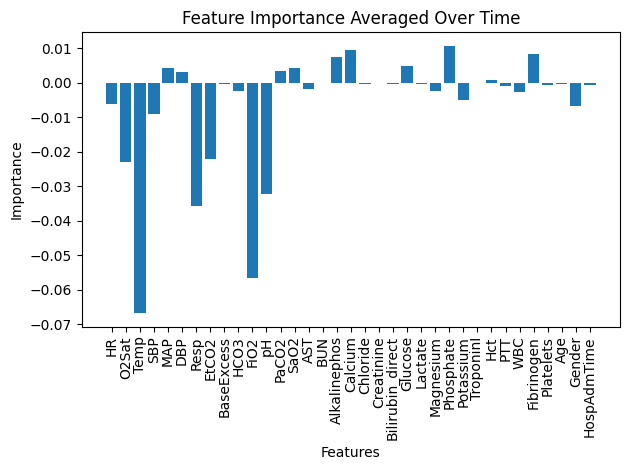

In [ ]:
import matplotlib.pyplot as plt

for patient in feature_importance_over_time[:1]:
	plt.bar(features, patient)

	plt.xticks(rotation=90)  # Rotate x-axis labels vertically
	plt.xlabel('Features')
	plt.ylabel('Importance')
	plt.title('Feature Importance Averaged Over Time')
	plt.tight_layout()  # Ensure everything fits within the figure
	plt.show()

In [325]:
feature_importance_over_time.shape

(1800, 35)

In [327]:
df_feature_importance_over_time = pd.DataFrame(feature_importance_over_time, columns=features)
df_feature_importance_over_time_sepsis_label = pd.DataFrame(feature_importance_over_time_sepsis_label, columns=features)
df_feature_importance_over_time_no_sepsis_label = pd.DataFrame(feature_importance_over_time_no_sepsis_label, columns=features)
df_feature_importance_over_time_sepsis_predicted = pd.DataFrame(feature_importance_over_time_sepsis_predicted, columns=features)
df_feature_importance_over_time_no_sepsis_predicted = pd.DataFrame(feature_importance_over_time_no_sepsis_predicted, columns=features)

In [328]:
df_feature_importance_over_time

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Potassium,TroponinI,Hct,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime
0,-0.006275,-0.022923,-0.066829,-0.008975,0.004247,0.003086,-0.035849,-0.022002,-0.000221,-0.002369,...,-0.005078,-3.382646e-07,0.000736,-0.000822,-0.002531,0.008385,-0.000625,-0.000260,-0.006822,-0.000650
1,-0.004527,-0.012948,-0.029609,-0.000910,-0.001619,-0.001584,-0.013612,0.008826,-0.001146,0.000074,...,-0.008478,-2.304917e-08,0.000273,-0.001122,0.000956,0.008172,0.000056,0.001899,-0.006538,-0.000503
2,-0.004299,-0.006098,-0.002139,-0.009228,-0.002512,-0.004323,-0.007231,0.004555,-0.001016,-0.000166,...,-0.009214,1.812724e-07,-0.000093,-0.001007,0.000296,0.006589,-0.000332,0.001355,-0.005710,-0.000343
3,-0.007461,-0.002410,0.001568,-0.001888,-0.001076,-0.001566,-0.003093,0.003068,-0.000553,-0.000250,...,-0.006712,3.972032e-08,-0.000015,-0.000687,0.000136,0.004869,-0.000056,0.000279,-0.004529,-0.000215
4,-0.003465,-0.000406,0.001727,-0.001344,-0.000704,-0.001779,-0.001062,0.000001,-0.000149,-0.000236,...,-0.003782,-8.768261e-09,-0.000022,-0.000432,0.000048,0.002961,-0.000181,-0.000427,-0.003040,-0.000124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,-0.001221,-0.012677,-0.002086,-0.002485,-0.001134,-0.001846,-0.031339,-0.015887,-0.000055,0.000143,...,-0.003381,-1.273212e-07,0.000479,-0.003735,0.002429,0.000007,-0.006678,-0.003796,-0.005795,-0.000418
1796,-0.001330,-0.006017,-0.000069,-0.002594,-0.000825,-0.001919,-0.015725,0.002927,0.000100,-0.000127,...,-0.006629,4.758548e-09,-0.000355,-0.002502,0.000942,0.000909,-0.003560,-0.002391,-0.005241,-0.000429
1797,-0.000246,-0.001342,0.000304,-0.000897,-0.000464,-0.002320,-0.006388,0.001920,0.000032,-0.000225,...,-0.004696,-2.431652e-08,-0.000206,-0.001290,0.000351,0.000664,-0.002091,-0.001895,-0.004022,-0.000341
1798,-0.001479,-0.000793,-0.000021,-0.000578,-0.000564,-0.001959,-0.001976,0.000183,-0.000042,-0.000239,...,-0.002849,-1.955729e-08,-0.000076,-0.000732,0.000122,0.000010,-0.001238,-0.001402,-0.002649,-0.000217


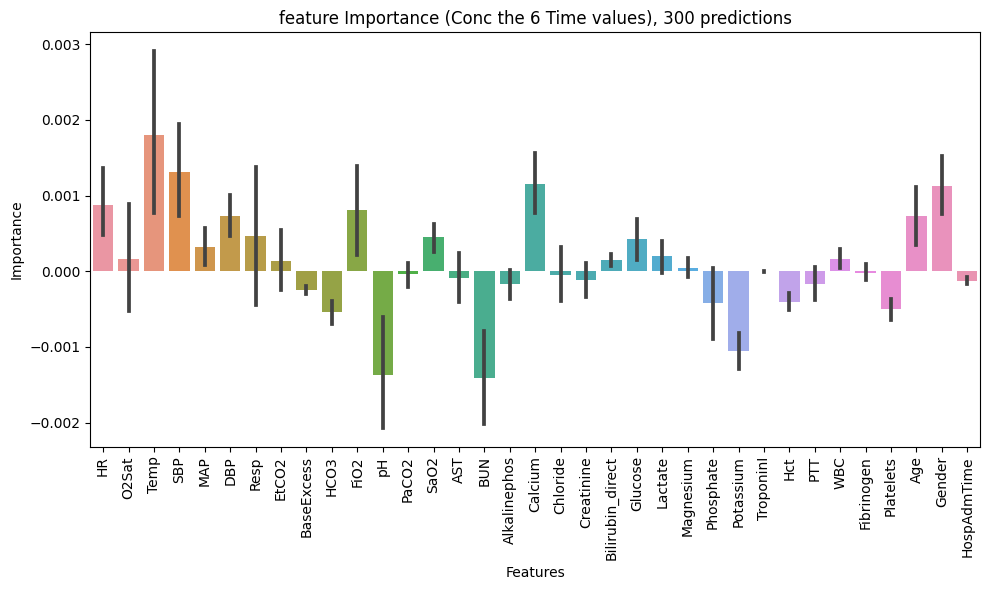

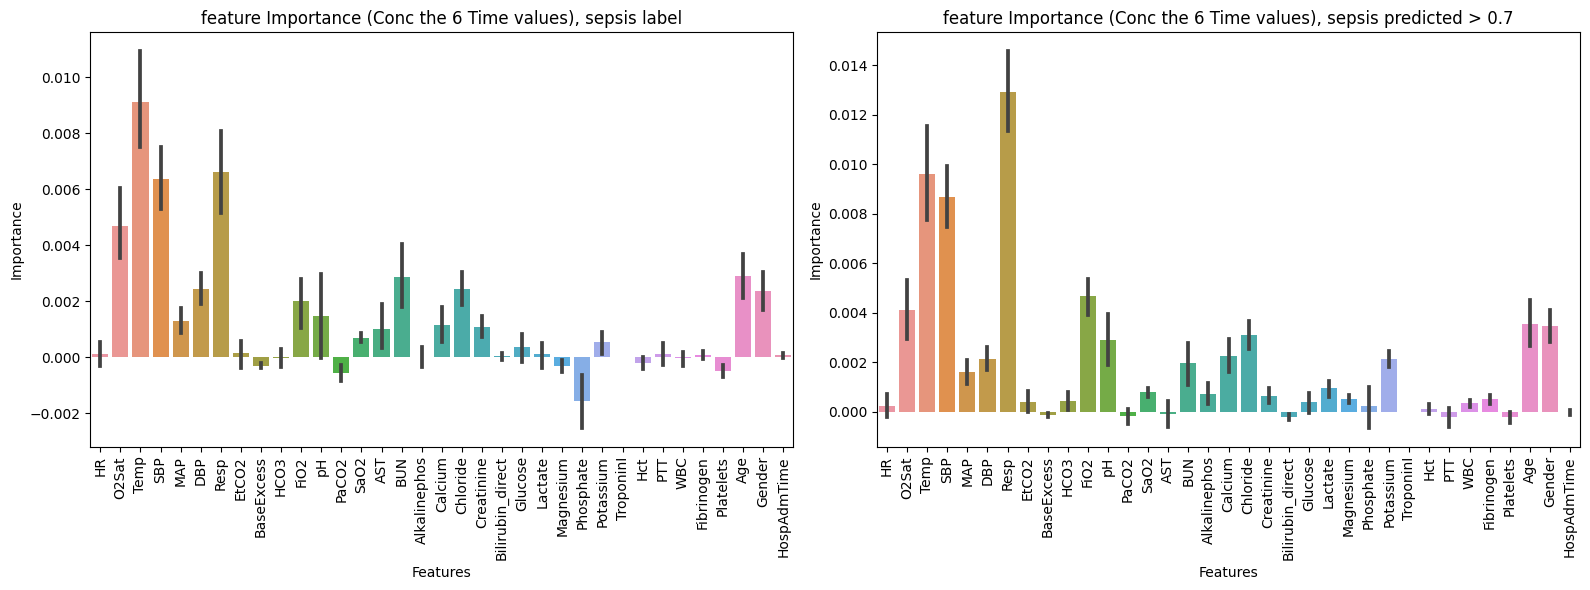

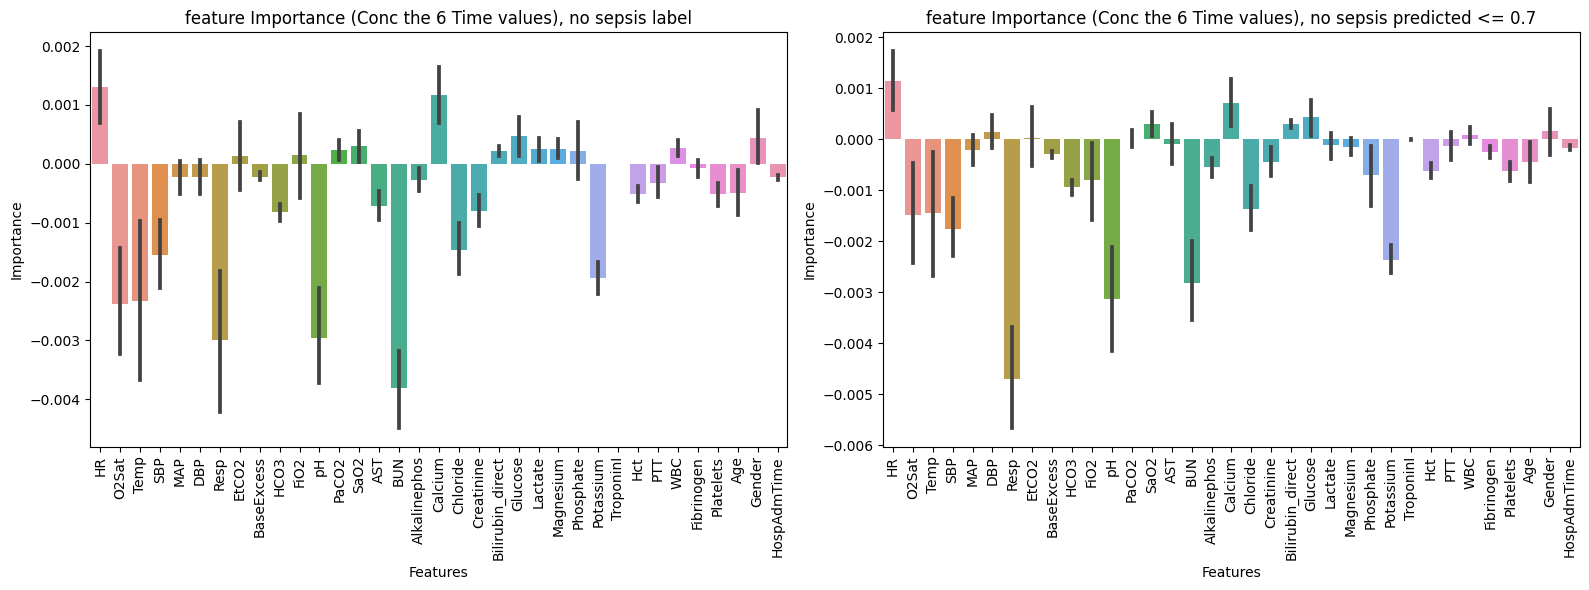

In [330]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the first figure (Fig 1)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_feature_importance_over_time)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('feature Importance (Conc the 6 Time values), 300 predictions')
plt.tight_layout()
plt.show()

# Create the second figure with Figs 2 and 4 side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=df_feature_importance_over_time_sepsis_label, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Importance')
axes[0].set_title('feature Importance (Conc the 6 Time values), sepsis label')

sns.barplot(data=df_feature_importance_over_time_sepsis_predicted, ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('feature Importance (Conc the 6 Time values), sepsis predicted > '+str(threshold))

plt.tight_layout()
plt.show()

# Create the third figure with Figs 3 and 5 side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=df_feature_importance_over_time_no_sepsis_label, ax=axes[0])
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Importance')
axes[0].set_title('feature Importance (Conc the 6 Time values), no sepsis label')

sns.barplot(data=df_feature_importance_over_time_no_sepsis_predicted, ax=axes[1])
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].set_title('feature Importance (Conc the 6 Time values), no sepsis predicted <= '+str(threshold))

plt.tight_layout()
plt.show()


In [352]:
def extract_sequences(test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6):
	"""
	Prépare les données d'entraînement et de test pour l'extraction de séquences
	"""
	# Supprimer la colonne des labels pour les features
	test_df.drop(columns=drop_column, inplace=True)

	# Sélectionner les colonnes de caractéristiques
	feature_cols = [col for col in train_df.columns if col not in exclude_columns]

	sequences_test, labels_test = extract_sequences_and_labels(
		test_df, id_column, time_column, feature_cols, label_column, sequence_length
	)

	return sequences_test, labels_test

In [342]:
def draw_patient_pred(id):
	data_array = shap_values_all[id]
	text_array = data_to_explain[id]
	plt.figure(figsize=(40, 8))  # Adjust the figure size as needed
	ax = sns.heatmap(data_array, annot=text_array, xticklabels=features,fmt=".2f", cmap="viridis", cbar=True,
					 annot_kws={"color": "white", "fontsize": 10})
	ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
	ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

	plt.show()

In [ ]:
original_sequences=extract_sequences(test_df, exclude_columns=['Patient_ID', 'Hour', 'Sepsispredicted'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6))

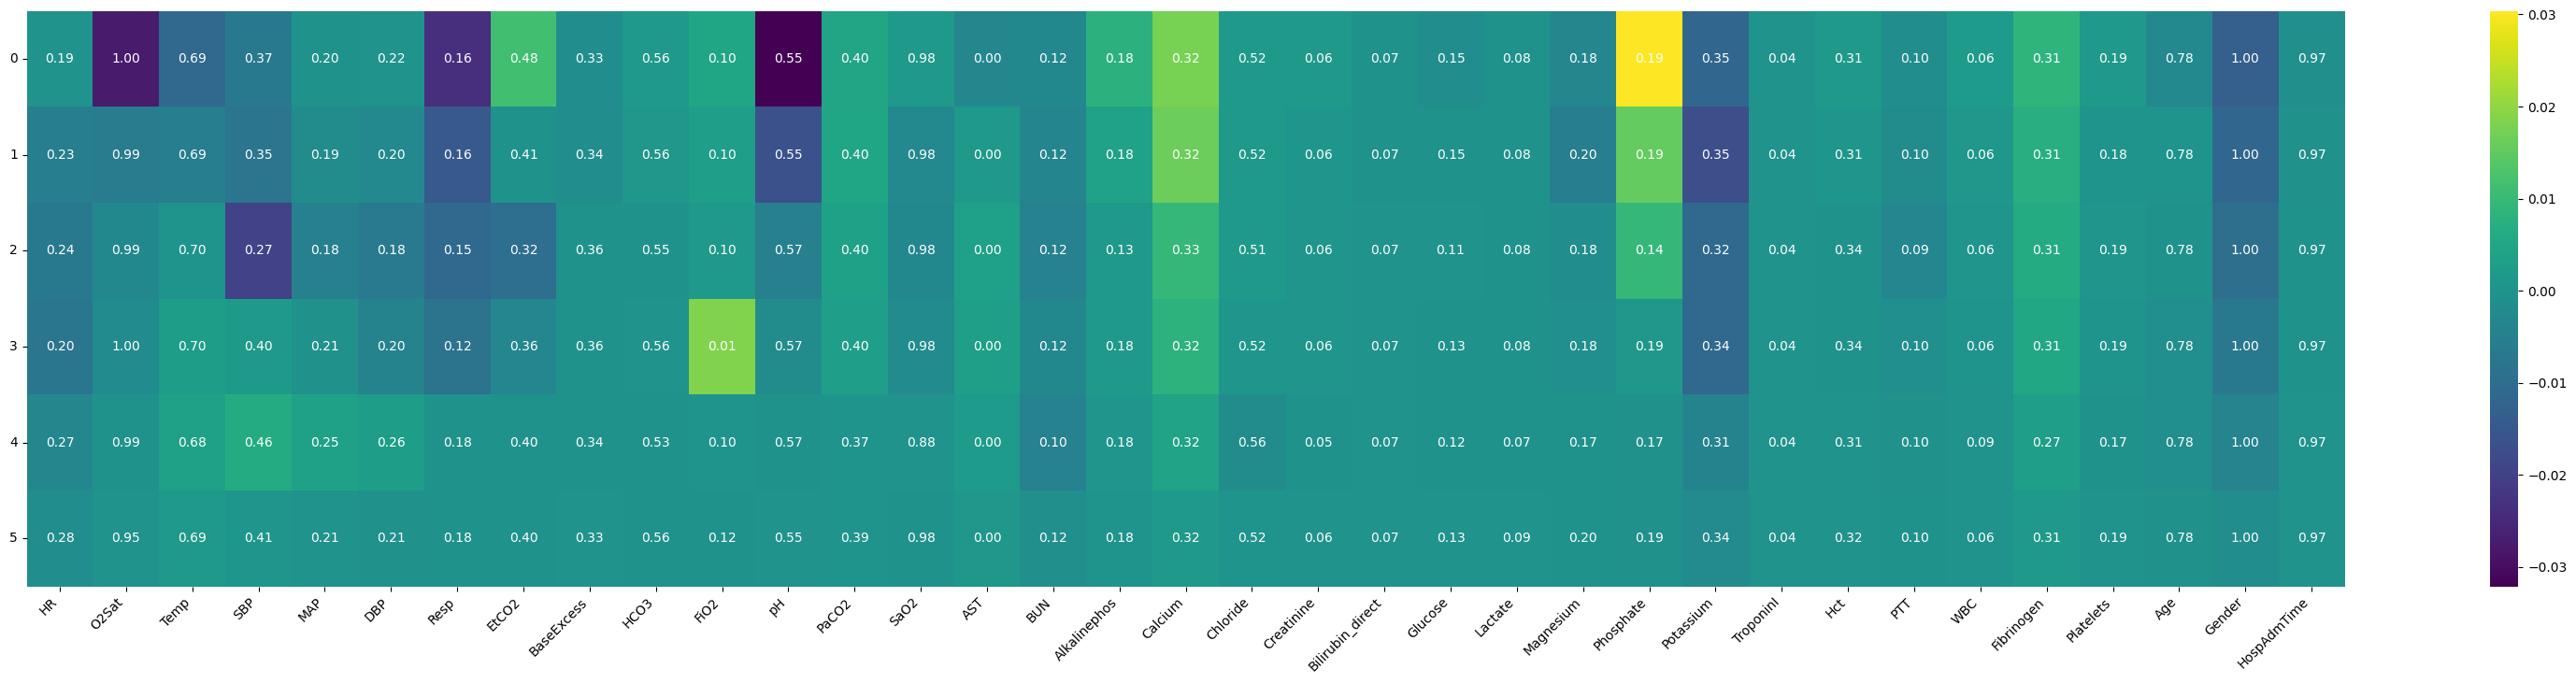

In [343]:
draw_patient_pred(3)